#### Implement Mahalonobis distance on the fan data


In [1]:
from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import random
from scipy import stats
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
# Print versions
!python3 --version
print('Numpy ' + np.__version__)
print('Pandas ' + pd.__version__)
print('SciPy ' + sp.__version__)

Python 3.8.6
Numpy 1.18.5
Pandas 1.1.1
SciPy 1.4.1


In [33]:
# Settings
dataset_path = "../datasets/home_fan_csv"  # Directory where raw accelerometer data is stored
normal_op_list = ['low_spd']
anomaly_op_list = ['mid_spd', 'off', 'high_spd']

val_ratio = 0.2             # Percentage hold for validation set
test_ratio = 0.2
raw_scale = 1               # Multiply raw values to fit into ints

sensor_sample_rate = 100    # Hz
desired_sample_rate = 50    # Hz

sample_time = 2             # Sample length (sec)
samples_per_file = 200      # Expected no of measurments in each file
max_anomaly_samples = 500   # # Max number of (shuffled) anomaly samples to use

max_measurements = int(sample_time * sensor_sample_rate)
downsample_factor = int(samples_per_file / desired_sample_rate)

md_file_name = 'mahalonobis_distance/models/md_model-moving'   # Mahalanobis Distance model arrays (.npz will be added)

print('Max measurements per file:', max_measurements)
print('Downsample factor:', downsample_factor)

Max measurements per file: 200
Downsample factor: 4


In [34]:
# Create list of filenames
def createFilenameList(op_list):
    
    # Extract paths and filenames in each directory
    op_filenames = []
    num_samples = 0
    for index, target in enumerate(op_list):
        samples_in_dir = listdir(join(dataset_path, target))
        samples_in_dir = [join(dataset_path, target, sample) for sample in samples_in_dir]
        op_filenames.append(samples_in_dir)
    
    # Flatten list
    return [item for sublist in op_filenames for item in sublist]

In [35]:
# Create normal and anomaly filename lists
normal_op_filenames = createFilenameList(normal_op_list)
anomaly_op_filenames = createFilenameList(anomaly_op_list)
print('Number of normal samples:', len(normal_op_filenames))
print('Number of anomaly samples:', len(anomaly_op_filenames))

Number of normal samples: 45
Number of anomaly samples: 117


In [36]:
# Shuffle lists
random.shuffle(normal_op_filenames)
random.shuffle(anomaly_op_filenames)

In [37]:
# Calculate validation and test set sizes
val_set_size = int(len(normal_op_filenames) * val_ratio)
test_set_size = int(len(normal_op_filenames) * test_ratio)

In [38]:
# Break dataset apart into train, validation, and test sets
num_samples = len(normal_op_filenames)
filenames_val = normal_op_filenames[:val_set_size]
filenames_test = normal_op_filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = normal_op_filenames[(val_set_size + test_set_size):]

# Print out number of samples in each set
print('Number of training samples:', len(filenames_train))
print('Number of validation samples:', len(filenames_val))
print('Number of test samples:', len(filenames_test))

# Check that our splits add up correctly
assert(len(filenames_train) + len(filenames_val) + len(filenames_test)) == num_samples

Number of training samples: 27
Number of validation samples: 9
Number of test samples: 9


In [39]:
# Function: extract specified features (variances, MAD) from sample
def extract_features(sample, max_measurements=0, scale=1):
    
    features = []
    
    # Truncate sample
    if max_measurements == 0:
        max_measurements = sample.shape[0]
    sample = sample[0:max_measurements]
    
    # Scale sample
    sample = scale * sample
    
#     # Variance
#     features.append(np.var(sample, axis=0))
    
#     # Kurtosis
#     features.append(stats.kurtosis(sample))
    
#     # Skew
#     features.append(stats.skew(sample))
    
    # Median absolute deviation (MAD)
    features.append(stats.median_absolute_deviation(sample))
    
#     # Correlation
#     cov = np.corrcoef(sample.T)
#     features.append(np.array([cov[0,1], cov[0,2], cov[1,2]]))
    
    # Compute a windowed FFT of each axis in the sample (leave off DC)
#     sample = sample[::downsample_factor, :]  # Downsample
#     sample = np.floor(sample)                # Round down to int
#     hann_window = np.hanning(sample.shape[0])
#     for i, axis in enumerate(sample.T):
#         fft = abs(np.fft.rfft(axis * hann_window))
#         features.append(fft[1:])  # Leave off DC
    
    return np.array(features).flatten()

(3,)
[0.16062174 0.38779852 0.56350588]


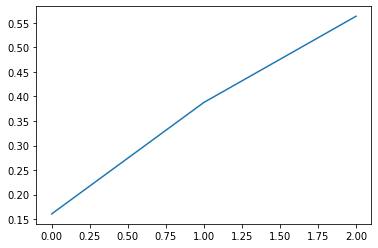

In [40]:
# Test with 1 sample
sample = np.genfromtxt(filenames_train[0], delimiter=',')
features = extract_features(sample, max_measurements, scale=raw_scale)
print(features.shape)
print(features)
plt.plot(features)

In [41]:
# Function: loop through filenames, creating feature sets
def create_feature_set(filenames):
    x_out = []
    for file in filenames:
        sample = np.genfromtxt(file, delimiter=',')
        features = extract_features(sample, max_measurements, raw_scale)
        x_out.append(features)
        
    return np.array(x_out)

In [42]:
# Create training, validation, and test sets
x_train = create_feature_set(filenames_train)
print('Extracted features from training set. Shape:', x_train.shape)
x_val = create_feature_set(filenames_val)
print('Extracted features from validation set. Shape:', x_val.shape)
x_test = create_feature_set(filenames_test)
print('Extracted features from test set. Shape:', x_test.shape)

Extracted features from training set. Shape: (27, 3)
Extracted features from validation set. Shape: (9, 3)
Extracted features from test set. Shape: (9, 3)


In [43]:
# Use training data (normal) to calculate mean and covariance matrices
model_mu = np.mean(x_train, axis=0)
model_cov = np.cov(x_train.T)
print(model_mu)
print(model_cov)

[0.1898073  0.32088118 0.62168061]
[[0.00437293 0.00152596 0.01917812]
 [0.00152596 0.01396126 0.0150105 ]
 [0.01917812 0.0150105  0.09495175]]


In [44]:
# Calculate mahalanobis distance of x from group described by mu, cov
# Based on: https://www.machinelearningplus.com/statistics/mahalanobis-distance/
def mahalanobis(x, mu, cov):
    x_minus_mu = x - mu
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    if mahal.shape == ():
        return mahal
    else:
        return mahal.diagonal()

Average MD for normal validation set: 2.400812369835592
Standard deviation of MDs for normal validation set: 1.2422270775514161
Recommended threshold (3x std dev + avg): 6.1274936024898405


(array([1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 1.]),
 array([0.75288037, 0.94404499, 1.1352096 , 1.32637422, 1.51753884,
        1.70870346, 1.89986808, 2.0910327 , 2.28219732, 2.47336194,
        2.66452656, 2.85569118, 3.0468558 , 3.23802042, 3.42918504,
        3.62034966, 3.81151427, 4.00267889, 4.19384351, 4.38500813,
        4.57617275]),
 <BarContainer object of 20 artists>)

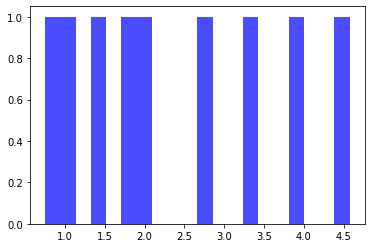

In [45]:
# Calculate the mahalanobis distance for each validation sample
normal_mds = mahalanobis(x_val, model_mu, model_cov)
print('Average MD for normal validation set:', np.average(normal_mds))
print('Standard deviation of MDs for normal validation set:', np.std(normal_mds))
print('Recommended threshold (3x std dev + avg):', (3*np.std(normal_mds)) + np.average(normal_mds))
fig, ax = plt.subplots(1,1)
ax.hist(normal_mds, bins=20, label='normal', color='blue', alpha=0.7)

In [46]:
# Extract features from anomaly test set (truncate to length of X test set)
anomaly_features = create_feature_set(anomaly_op_filenames[:max_anomaly_samples])
print('Extracted features from anomaly set. Shape:', anomaly_features.shape)

Extracted features from anomaly set. Shape: (117, 3)


In [47]:
# Calculate the mahalanobis distance for each anomaly sample
anomaly_mds = mahalanobis(anomaly_features, model_mu, model_cov)
print('Average MD for anomaly set:', np.average(anomaly_mds))
print('Standard deviation of MDs for validation set:', np.std(anomaly_mds))

Average MD for anomaly set: 66.02848949998847
Standard deviation of MDs for validation set: 101.42659040420789


(array([43., 47.,  2.,  3.,  4.,  3.,  1.,  0.,  0.,  1.,  3.,  0.,  1.,
         1.,  2.,  3.,  0.,  1.,  1.,  1.]),
 array([6.50329990e-02, 2.27765238e+01, 4.54880147e+01, 6.81995055e+01,
        9.09109963e+01, 1.13622487e+02, 1.36333978e+02, 1.59045469e+02,
        1.81756960e+02, 2.04468450e+02, 2.27179941e+02, 2.49891432e+02,
        2.72602923e+02, 2.95314414e+02, 3.18025905e+02, 3.40737395e+02,
        3.63448886e+02, 3.86160377e+02, 4.08871868e+02, 4.31583359e+02,
        4.54294850e+02]),
 <BarContainer object of 20 artists>)

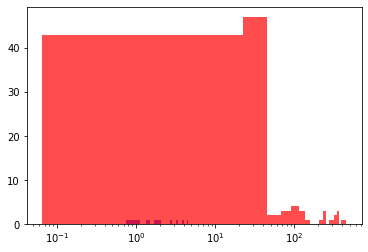

In [48]:
# Plot histograms of normal validation vs. anomaly sets (MSEs)
fig, ax = plt.subplots(1,1)
plt.xscale("log")
ax.hist(normal_mds, bins=20, label='normal', color='blue', alpha=0.7)
ax.hist(anomaly_mds, bins=20, label='anomaly', color='red', alpha=0.7)

In [49]:
# Create a classifier (0 = normal, 1 = anomaly)
def detect_anomaly(x, model_mu, model_cov, threshold=0):
    md = mahalanobis(x, model_mu, model_cov)
    if md > threshold:
        return 1
    else:
        return 0

In [63]:
# Choose a threshold
anomaly_threshold = 6

In [64]:
# Perform classification on test set
pred_test = [detect_anomaly(x, model_mu, model_cov, anomaly_threshold) for x in x_test]
print(pred_test)

[0, 0, 0, 0, 0, 0, 0, 1, 0]


In [65]:
# Perform classification on anomaly set
pred_anomaly = [detect_anomaly(x, model_mu, model_cov, anomaly_threshold) for x in anomaly_features]
print(pred_anomaly)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]


In [66]:
# Combine predictions into one long list and create a label list
pred = np.array(pred_test + pred_anomaly)
labels = ([0] * len(pred_test)) + ([1] * len(pred_anomaly))

In [73]:
# Create confusion matrix
cm = confusion_matrix(labels, pred)
print(cm)

# Unbundle confusion matrix
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

# Recall
recall = tp/(tp + fn)
print("Recall : ", recall)

# Precision
precision = tp + (tp + fp)
print("Precision : ", precision)

# F-score
f_score = (2*recall*precision)/(recall+precision)
print("F-score: ", f_score)

[[ 8  1]
 [21 96]]
1
Recall :  0.27586206896551724
Precision :  17
F-score:  0.5429141716566867


Text(33.0, 0.5, 'Actual')

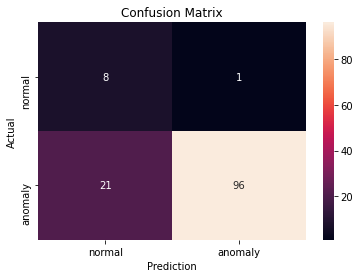

In [68]:
# Make confusion matrix pretty
df_cm = pd.DataFrame(cm, index=['normal', 'anomaly'], columns=['normal', 'anomaly'])
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [62]:
# Save Mahalanobis Distance model
np.savez(md_file_name + '.npz', model_mu=model_mu, model_cov=model_cov)

FileNotFoundError: [Errno 2] No such file or directory: 'mahalonobis_distance/models/md_model-moving.npz'